In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from timm import create_model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch_ema import ExponentialMovingAverage
from timm.data.mixup import Mixup
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

### Config

In [2]:
# ----------------- Settings -----------------
DATA_DIR = "/Users/nelson/py/paper_impl/emotion_classifier/fane_dataset"
SAVE_DIR = "models"
NUM_CLASSES = 9
IMG_SIZE = 256
EPOCHS = 50
BATCH_SIZE = 32
GRAD_ACCUM = 4
USE_EMA = True
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
# ----------------- Custom Loss -----------------
class ClassBalancedFocalLoss(nn.Module):
    def __init__(self, beta, gamma, class_counts):
        super().__init__()
        class_counts = torch.tensor(class_counts, dtype=torch.float32).to(device)
        effective_num = 1.0 - torch.pow(beta, class_counts)
        weights = (1.0 - beta) / effective_num
        weights = weights / weights.sum() * NUM_CLASSES
        self.class_weights = weights
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.class_weights, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# ----------------- Temperature Scaling -----------------
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature(model, val_loader):
    scaler = TemperatureScaler().to(device)
    model.eval().to(device)
    logits_list, labels_list = [], []

    if ema:
        ema.store()
        ema.copy_to(model.parameters())

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits_list.append(model(x))
            labels_list.append(y)

    if ema:
        ema.restore()

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)
    optimizer = torch.optim.LBFGS([scaler.temperature], lr=0.01, max_iter=50)

    def eval_fn():
        optimizer.zero_grad()
        loss = F.cross_entropy(scaler(logits), labels)
        loss.backward()
        return loss

    optimizer.step(eval_fn)
    print(f"\U0001f321️ Calibrated Temp: {scaler.temperature.item():.4f}")
    return scaler

In [4]:
# ----------------- Data Transforms -----------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ----------------- Class Weights + Loss -----------------
train_targets = np.array(train_ds.targets)
class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)
criterion = ClassBalancedFocalLoss(beta=0.999, gamma=1.5, class_counts=class_counts)

In [5]:
print("Train classes:", train_ds.classes)
print("Validation classes:", val_ds.classes)

assert train_ds.classes == val_ds.classes, "Class mismatch between train and validation sets!"

Train classes: ['angry', 'confused', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'shy', 'surprise']
Validation classes: ['angry', 'confused', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'shy', 'surprise']



📅 Epoch 1/50
Unfreezing Stage 4 (deepest)


🪝️ Train 01:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 01:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 01 | 🔁 LR: 1.52e-05 | 🎯 Acc: 0.2657 | 🧠 F1: 0.2097 | 📉 Loss: 1.6946
🔥 Saved best model at epoch 1 with F1 = 0.2097

📅 Epoch 2/50
Unfreezing Stage 3


🪝️ Train 02:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 02:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 02 | 🔁 LR: 2.45e-05 | 🎯 Acc: 0.3209 | 🧠 F1: 0.2675 | 📉 Loss: 1.5493
🔥 Saved best model at epoch 2 with F1 = 0.2675

📅 Epoch 3/50


🪝️ Train 03:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 03:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 03 | 🔁 LR: 3.95e-05 | 🎯 Acc: 0.3867 | 🧠 F1: 0.3620 | 📉 Loss: 1.4408
🔥 Saved best model at epoch 3 with F1 = 0.3620

📅 Epoch 4/50
Unfreezing Stage 2


🪝️ Train 04:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 04:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 04 | 🔁 LR: 5.97e-05 | 🎯 Acc: 0.4182 | 🧠 F1: 0.3971 | 📉 Loss: 1.3561
🔥 Saved best model at epoch 4 with F1 = 0.3971

📅 Epoch 5/50


🪝️ Train 05:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 05:   0%|          | 0/80 [00:04<?, ?it/s]

✅ Epoch 05 | 🔁 LR: 8.41e-05 | 🎯 Acc: 0.4505 | 🧠 F1: 0.4442 | 📉 Loss: 1.2831
🔥 Saved best model at epoch 5 with F1 = 0.4442

📅 Epoch 6/50
Unfreezing Stage 1 (earliest layers)


🪝️ Train 06:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 06:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 06 | 🔁 LR: 1.12e-04 | 🎯 Acc: 0.4769 | 🧠 F1: 0.4708 | 📉 Loss: 1.2226
🔥 Saved best model at epoch 6 with F1 = 0.4708

📅 Epoch 7/50


🪝️ Train 07:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 07:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 07 | 🔁 LR: 1.41e-04 | 🎯 Acc: 0.4966 | 🧠 F1: 0.4940 | 📉 Loss: 1.1684
🔥 Saved best model at epoch 7 with F1 = 0.4940

📅 Epoch 8/50


🪝️ Train 08:   0%|          | 0/370 [00:04<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validate 08:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 08 | 🔁 LR: 1.71e-04 | 🎯 Acc: 0.5175 | 🧠 F1: 0.5072 | 📉 Loss: 1.1345
🔥 Saved best model at epoch 8 with F1 = 0.5072

📅 Epoch 9/50


🪝️ Train 09:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 09:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 09 | 🔁 LR: 2.01e-04 | 🎯 Acc: 0.5333 | 🧠 F1: 0.5297 | 📉 Loss: 1.0900
🔥 Saved best model at epoch 9 with F1 = 0.5297

📅 Epoch 10/50


🪝️ Train 10:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 10:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 10 | 🔁 LR: 2.28e-04 | 🎯 Acc: 0.5424 | 🧠 F1: 0.5376 | 📉 Loss: 1.0613
🔥 Saved best model at epoch 10 with F1 = 0.5376

📅 Epoch 11/50


🪝️ Train 11:   0%|          | 0/370 [00:04<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validate 11:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 11 | 🔁 LR: 2.53e-04 | 🎯 Acc: 0.5522 | 🧠 F1: 0.5508 | 📉 Loss: 1.0579
🔥 Saved best model at epoch 11 with F1 = 0.5508

📅 Epoch 12/50


🪝️ Train 12:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 12:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 12 | 🔁 LR: 2.73e-04 | 🎯 Acc: 0.5609 | 🧠 F1: 0.5580 | 📉 Loss: 1.0192
🔥 Saved best model at epoch 12 with F1 = 0.5580

📅 Epoch 13/50


🪝️ Train 13:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 13:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 13 | 🔁 LR: 2.88e-04 | 🎯 Acc: 0.5743 | 🧠 F1: 0.5693 | 📉 Loss: 0.9954
🔥 Saved best model at epoch 13 with F1 = 0.5693

📅 Epoch 14/50


🪝️ Train 14:   0%|          | 0/370 [00:04<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validate 14:   0%|          | 0/80 [00:04<?, ?it/s]

✅ Epoch 14 | 🔁 LR: 2.97e-04 | 🎯 Acc: 0.5775 | 🧠 F1: 0.5740 | 📉 Loss: 0.9805
🔥 Saved best model at epoch 14 with F1 = 0.5740

📅 Epoch 15/50


🪝️ Train 15:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 15:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 15 | 🔁 LR: 3.00e-04 | 🎯 Acc: 0.5759 | 🧠 F1: 0.5742 | 📉 Loss: 0.9736
🔥 Saved best model at epoch 15 with F1 = 0.5742

📅 Epoch 16/50


🪝️ Train 16:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 16:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 16 | 🔁 LR: 2.99e-04 | 🎯 Acc: 0.5798 | 🧠 F1: 0.5789 | 📉 Loss: 0.9180
🔥 Saved best model at epoch 16 with F1 = 0.5789

📅 Epoch 17/50


🪝️ Train 17:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 17:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 17 | 🔁 LR: 2.98e-04 | 🎯 Acc: 0.5794 | 🧠 F1: 0.5785 | 📉 Loss: 0.9080

📅 Epoch 18/50


🪝️ Train 18:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 18:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 18 | 🔁 LR: 2.95e-04 | 🎯 Acc: 0.5952 | 🧠 F1: 0.5922 | 📉 Loss: 0.8995
🔥 Saved best model at epoch 18 with F1 = 0.5922

📅 Epoch 19/50


🪝️ Train 19:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 19:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 19 | 🔁 LR: 2.90e-04 | 🎯 Acc: 0.5972 | 🧠 F1: 0.5946 | 📉 Loss: 0.8645
🔥 Saved best model at epoch 19 with F1 = 0.5946

📅 Epoch 20/50


🪝️ Train 20:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 20:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 20 | 🔁 LR: 2.85e-04 | 🎯 Acc: 0.5897 | 🧠 F1: 0.5883 | 📉 Loss: 0.8367

📅 Epoch 21/50


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


🪝️ Train 21:   0%|          | 0/370 [00:30<?, ?it/s]

Validate 21:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 21 | 🔁 LR: 2.79e-04 | 🎯 Acc: 0.6098 | 🧠 F1: 0.6065 | 📉 Loss: 0.8304
🔥 Saved best model at epoch 21 with F1 = 0.6065

📅 Epoch 22/50


🪝️ Train 22:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 22:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 22 | 🔁 LR: 2.71e-04 | 🎯 Acc: 0.6078 | 🧠 F1: 0.6051 | 📉 Loss: 0.8221

📅 Epoch 23/50


🪝️ Train 23:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 23:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 23 | 🔁 LR: 2.63e-04 | 🎯 Acc: 0.5964 | 🧠 F1: 0.5985 | 📉 Loss: 0.8137

📅 Epoch 24/50


🪝️ Train 24:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 24:   0%|          | 0/80 [00:05<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


✅ Epoch 24 | 🔁 LR: 2.54e-04 | 🎯 Acc: 0.6177 | 🧠 F1: 0.6170 | 📉 Loss: 0.8017
🔥 Saved best model at epoch 24 with F1 = 0.6170

📅 Epoch 25/50


🪝️ Train 25:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 25:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 25 | 🔁 LR: 2.43e-04 | 🎯 Acc: 0.6177 | 🧠 F1: 0.6153 | 📉 Loss: 0.7803

📅 Epoch 26/50


🪝️ Train 26:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 26:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 26 | 🔁 LR: 2.33e-04 | 🎯 Acc: 0.6251 | 🧠 F1: 0.6228 | 📉 Loss: 0.7410
🔥 Saved best model at epoch 26 with F1 = 0.6228

📅 Epoch 27/50


🪝️ Train 27:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 27:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 27 | 🔁 LR: 2.21e-04 | 🎯 Acc: 0.6244 | 🧠 F1: 0.6212 | 📉 Loss: 0.7251

📅 Epoch 28/50


🪝️ Train 28:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 28:   0%|          | 0/80 [00:04<?, ?it/s]

✅ Epoch 28 | 🔁 LR: 2.09e-04 | 🎯 Acc: 0.6259 | 🧠 F1: 0.6225 | 📉 Loss: 0.7521

📅 Epoch 29/50


🪝️ Train 29:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 29:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 29 | 🔁 LR: 1.96e-04 | 🎯 Acc: 0.6283 | 🧠 F1: 0.6260 | 📉 Loss: 0.7289
🔥 Saved best model at epoch 29 with F1 = 0.6260

📅 Epoch 30/50


🪝️ Train 30:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 30:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 30 | 🔁 LR: 1.83e-04 | 🎯 Acc: 0.6342 | 🧠 F1: 0.6300 | 📉 Loss: 0.6992
🔥 Saved best model at epoch 30 with F1 = 0.6300

📅 Epoch 31/50


🪝️ Train 31:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 31:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 31 | 🔁 LR: 1.70e-04 | 🎯 Acc: 0.6334 | 🧠 F1: 0.6308 | 📉 Loss: 0.6928
🔥 Saved best model at epoch 31 with F1 = 0.6308

📅 Epoch 32/50


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


🪝️ Train 32:   0%|          | 0/370 [00:30<?, ?it/s]

Validate 32:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 32 | 🔁 LR: 1.57e-04 | 🎯 Acc: 0.6315 | 🧠 F1: 0.6298 | 📉 Loss: 0.7090

📅 Epoch 33/50


🪝️ Train 33:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 33:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 33 | 🔁 LR: 1.43e-04 | 🎯 Acc: 0.6354 | 🧠 F1: 0.6305 | 📉 Loss: 0.7106

📅 Epoch 34/50


🪝️ Train 34:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 34:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 34 | 🔁 LR: 1.30e-04 | 🎯 Acc: 0.6362 | 🧠 F1: 0.6340 | 📉 Loss: 0.6772
🔥 Saved best model at epoch 34 with F1 = 0.6340

📅 Epoch 35/50


🪝️ Train 35:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 35:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 35 | 🔁 LR: 1.16e-04 | 🎯 Acc: 0.6330 | 🧠 F1: 0.6309 | 📉 Loss: 0.6790

📅 Epoch 36/50


🪝️ Train 36:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 36:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 36 | 🔁 LR: 1.04e-04 | 🎯 Acc: 0.6374 | 🧠 F1: 0.6335 | 📉 Loss: 0.6370

📅 Epoch 37/50


🪝️ Train 37:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 37:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 37 | 🔁 LR: 9.09e-05 | 🎯 Acc: 0.6338 | 🧠 F1: 0.6302 | 📉 Loss: 0.6577

📅 Epoch 38/50


🪝️ Train 38:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 38:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 38 | 🔁 LR: 7.88e-05 | 🎯 Acc: 0.6374 | 🧠 F1: 0.6340 | 📉 Loss: 0.6475

📅 Epoch 39/50


🪝️ Train 39:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 39:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 39 | 🔁 LR: 6.72e-05 | 🎯 Acc: 0.6378 | 🧠 F1: 0.6344 | 📉 Loss: 0.6441
🔥 Saved best model at epoch 39 with F1 = 0.6344

📅 Epoch 40/50


🪝️ Train 40:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 40:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 40 | 🔁 LR: 5.64e-05 | 🎯 Acc: 0.6425 | 🧠 F1: 0.6395 | 📉 Loss: 0.6484
🔥 Saved best model at epoch 40 with F1 = 0.6395

📅 Epoch 41/50


🪝️ Train 41:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 41:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 41 | 🔁 LR: 4.62e-05 | 🎯 Acc: 0.6429 | 🧠 F1: 0.6398 | 📉 Loss: 0.6572
🔥 Saved best model at epoch 41 with F1 = 0.6398

📅 Epoch 42/50


🪝️ Train 42:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 42:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 42 | 🔁 LR: 3.69e-05 | 🎯 Acc: 0.6421 | 🧠 F1: 0.6390 | 📉 Loss: 0.6640

📅 Epoch 43/50


🪝️ Train 43:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 43:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 43 | 🔁 LR: 2.86e-05 | 🎯 Acc: 0.6374 | 🧠 F1: 0.6337 | 📉 Loss: 0.6466

📅 Epoch 44/50


🪝️ Train 44:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 44:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 44 | 🔁 LR: 2.12e-05 | 🎯 Acc: 0.6405 | 🧠 F1: 0.6376 | 📉 Loss: 0.6358

📅 Epoch 45/50


🪝️ Train 45:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 45:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 45 | 🔁 LR: 1.48e-05 | 🎯 Acc: 0.6433 | 🧠 F1: 0.6392 | 📉 Loss: 0.6021

📅 Epoch 46/50


🪝️ Train 46:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 46:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 46 | 🔁 LR: 9.51e-06 | 🎯 Acc: 0.6370 | 🧠 F1: 0.6329 | 📉 Loss: 0.6295

📅 Epoch 47/50


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


🪝️ Train 47:   0%|          | 0/370 [00:49<?, ?it/s]

Validate 47:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 47 | 🔁 LR: 5.37e-06 | 🎯 Acc: 0.6453 | 🧠 F1: 0.6415 | 📉 Loss: 0.6118
🔥 Saved best model at epoch 47 with F1 = 0.6415

📅 Epoch 48/50


🪝️ Train 48:   0%|          | 0/370 [00:05<?, ?it/s]

Validate 48:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 48 | 🔁 LR: 2.39e-06 | 🎯 Acc: 0.6405 | 🧠 F1: 0.6379 | 📉 Loss: 0.6488

📅 Epoch 49/50


🪝️ Train 49:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 49:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 49 | 🔁 LR: 5.92e-07 | 🎯 Acc: 0.6433 | 🧠 F1: 0.6400 | 📉 Loss: 0.6258

📅 Epoch 50/50


🪝️ Train 50:   0%|          | 0/370 [00:04<?, ?it/s]

Validate 50:   0%|          | 0/80 [00:05<?, ?it/s]

✅ Epoch 50 | 🔁 LR: 1.27e-09 | 🎯 Acc: 0.6441 | 🧠 F1: 0.6406 | 📉 Loss: 0.6117
🌡️ Calibrated Temp: 1.1560

📊 Final Classification Report:
Final Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.58      0.58       266
    confused       0.51      0.42      0.46       193
     disgust       0.56      0.48      0.52       207
        fear       0.67      0.80      0.73       435
       happy       0.75      0.79      0.77       288
     neutral       0.71      0.64      0.68       275
         sad       0.64      0.65      0.64       410
         shy       0.58      0.62      0.60       185
    surprise       0.65      0.60      0.62       278

    accuracy                           0.64      2537
   macro avg       0.63      0.62      0.62      2537
weighted avg       0.64      0.64      0.64      2537



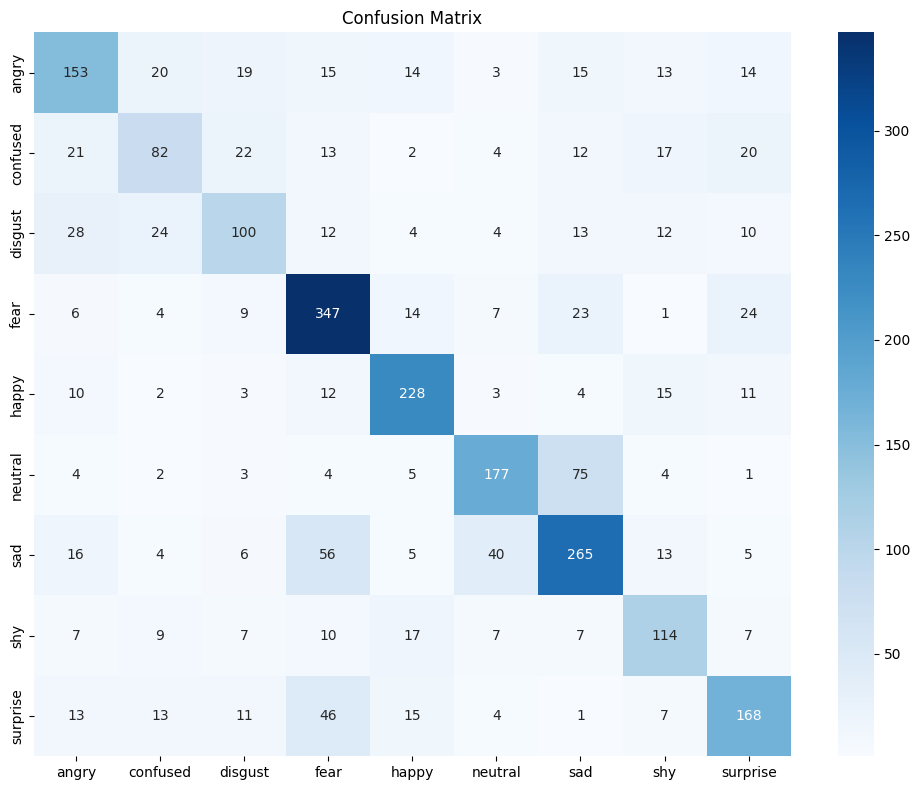

In [6]:
# ----------------- Model -----------------
model = create_model("mobilevitv2_100", pretrained=True)
feature_dim = model.get_classifier().in_features
model.reset_classifier(NUM_CLASSES)

for p in model.parameters():
    p.requires_grad = False
for p in model.get_classifier().parameters():
    p.requires_grad = True
model.to(device)

# ----------------- Optimizer and Scheduler -----------------
optimizer = torch.optim.AdamW([
    {"params": model.get_classifier().parameters(), "lr": 3e-4, "initial_lr": 3e-4, "max_lr": 3e-4, "min_lr": 3e-5}
])
steps_per_epoch = len(train_loader) // GRAD_ACCUM
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, pct_start=0.3, cycle_momentum=False
)
ema = ExponentialMovingAverage(model.parameters(), decay=0.995) if USE_EMA else None
mixup_fn = Mixup(
    mixup_alpha=0.2, 
    cutmix_alpha=0.2, 
    prob=0.5,
    num_classes=NUM_CLASSES
)

# ----------------- Unfreezing Helper -----------------
def unfreeze(module):
    for param in module.parameters():
        param.requires_grad = True

# ----------------- Training Loop -----------------
best_f1 = 0
best_model_path = None
for epoch in range(EPOCHS):
    print(f"\n\U0001f4c5 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    optimizer.zero_grad()

    if epoch == 0:
        print("Unfreezing Stage 4 (deepest)")
        unfreeze(model.stages[4])
        optimizer.add_param_group({"params": model.stages[4].parameters(), "lr": 1e-4, "initial_lr": 1e-4, "max_lr":1e-4, "min_lr":1e-5})
    if epoch == 1:
        print("Unfreezing Stage 3")
        unfreeze(model.stages[3])
        optimizer.add_param_group({"params": model.stages[3].parameters(), "lr": 1e-4, "initial_lr": 1e-4, "max_lr":1e-4, "min_lr":1e-5})
    if epoch == 3:
        print("Unfreezing Stage 2")
        unfreeze(model.stages[2])
        optimizer.add_param_group({"params": model.stages[2].parameters(), "lr": 1e-4, "initial_lr": 1e-4, "max_lr":1e-4, "min_lr":1e-5})
    if epoch == 5:
        print("Unfreezing Stage 1 (earliest layers)")
        unfreeze(model.stages[1])
        optimizer.add_param_group({"params": model.stages[1].parameters(), "lr": 5e-5, "initial_lr": 5e-5, "max_lr": 5e-5, "min_lr": 5e-6})

    running_loss = 0.0
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"\U0001fa9d️ Train {epoch+1:02d}")):
        x, y = x.to(device), y.to(device)
        x, y = mixup_fn(x, y)
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        running_loss += loss.item()

        if (i + 1) % GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            if ema:
                ema.update()

    
    avg_loss = running_loss / len(train_loader)

    if ema:
        ema.store()
        ema.copy_to(model.parameters())

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Validate {epoch+1:02d}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds += logits.argmax(1).cpu().tolist()
            targets += y.cpu().tolist()

    if ema:
        ema.restore()

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    print(f"✅ Epoch {epoch+1:02d} | 🔁 LR: {scheduler.get_last_lr()[0]:.2e} | 🎯 Acc: {acc:.4f} | 🧠 F1: {f1:.4f} | 📉 Loss: {avg_loss:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        if ema:
            ema.store()
            ema.copy_to(model.parameters())
            best_model_path = os.path.join(SAVE_DIR, f"best_model_ema_{epoch+1}.pth")  # ⬅️ store exact path
            torch.save(model.state_dict(), best_model_path)
            ema.restore()
        else:
            best_model_path = os.path.join(SAVE_DIR, f"best_model_{epoch+1}.pth")  # ⬅️ store exact path
            torch.save(model.state_dict(), best_model_path)
        print(f"🔥 Saved best model at epoch {epoch+1} with F1 = {f1:.4f}")

# ----------------- Final Evaluation -----------------
if best_model_path is not None and os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    calibrate_temperature(model, val_loader)

    print("\n📊 Final Classification Report:")
    # Evaluate with the best model...
else:
    print("❌ No best model was saved during training.")

print("Final Classification Report:")
print(classification_report(targets, preds, target_names=val_ds.classes))
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_ds.classes, yticklabels=val_ds.classes)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()